### <center> **HW3 - Variational inference and sampling methods** </center>
<center> Ron Maor </center>
<hr>

In [ ]:
!pip install jupyterplot

     |████████████████████████████████| 71kB 3.1MB/s 
  Created wheel for lrcurve: filename=lrcurve-1.1.0-cp37-none-any.whl size=69143 sha256=82276af41d95c31ae56b5d3899de32c7967a9ba8931c6368cf0c74e67c576746
  Stored in directory: /root/.cache/pip/wheels/75/a4/04/20e13c039859fa02094902e615d74fa46bfd6908906e31e278
Successfully built lrcurve


In [ ]:
import jax
import jax.numpy as np
from jax import random, jit, vmap, grad, value_and_grad, jacfwd
from jax.scipy.stats import multivariate_normal
from jax.tree_util import tree_multimap
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy.stats as stats
import numpy as onp
import seaborn as sns
import pandas as pd

from jax.experimental import optimizers
import jax.scipy.stats.norm as norm
from jax.nn import sigmoid, log_sigmoid

import itertools
import numpy.random as npr
from tqdm import trange
from functools import partial
import matplotlib.pyplot as plt

from tqdm.notebook import trange, tqdm

from jupyterplot import ProgressPlot

plt.style.use('ggplot')

## Problem 1

Please answer the following questions by providing a short explanation:

**(1)** Is KL divergence symmetric?

**(2)** Is KL divergence positive or negative? Please prove your answer.

**(3)** Is there any drawbacks of using KL divergence?

**(4)** What is the connection between cross-entropy and KL divergence?

**(5)** Why cross-entropy loss is a good choice for multi-class classification?

##### ***Answer***

**(1)** <br>
KL divergence is **not** symmetric. This can be seen straight from the definition:

$$ \begin{align} KL(P||Q)=\sum p(x) ln \left( \frac{p(x)}{q(x)}\right) \end{align}$$ <br>

Hence:

$$ \begin{align} KL(P||Q) - KL(Q||P) &= \sum ln \left( \frac{p(x)}{q(x)}\right)(p(x) + q(x)) \end{align}$$

Which is not necessarily zero. <br><br>

**(2)**<br>
Since logaritm function is strictly concave we know that:

$$ ln(x) \leq x-1 $$

Using this inequality with the KL divergence definition we get:

$$ \begin{align}
-KL(p||q)&=-\sum_x p(x)\ln \frac{p(x)}{q(x)}\\
&= \sum_x p(x)\ln \frac{q(x)}{p(x)}\\
&{\leq} \sum_x p(x)\left(\frac{q(x)}{p(x)}-1\right)\\
&=\sum_x q(x) - \sum_x p(x)\\
&= 1 - 1\\
&= 0
\end{align} \\ \Rightarrow -KL(p||q) \leq 0 \\
\downarrow \\
\Rightarrow \boxed{KL(p||q) \geq 0}$$

**(3)**<br>
No method is completely perfect, and it always depends on the situation and context. One thing to watch our for in KL divergence is the term in the denominator of the logarithm function. If a sample in that reigon is very small or close to zero, there is a large penalty for that. In other words, we want the two distribution to overlap in certain regions.


**(4)**<br>
By definition, the KL divergence is the difference between the cross entropy $H(p,q)$ and the enntropoy $H(p)$:

$$ KL(p||q) = H(p,q) - H(q) = -\sum p(x)ln\,q(x) + \sum p(x) ln \, p(x) $$


**(5)**<br>
Cross entropy gets larger when the uncertanity is higher, and for classification tasks it means that the cross entropy will be higher when the prediction is far away from the true label.

## Problem 2

Consider a Bayesian model with parameters $θ$ for which you want to maximize its marginal log-likelihood $\log p(\mathcal{D})$ given some observed data $D$. As this objective is generally intractable, assume a variational approximation to the posterior by introducing an auxiliary distribution $q ( θ | D )$.

***(1)*** Please derive the following inequality :

$$ \log p(\mathcal{D}) \geq \mathbb{E}_{q(\theta\lvert\mathcal{D})}\log p(\mathcal{D}\lvert \theta) + \mathbb{E}_{q(\theta\lvert\mathcal{D})}\log p(\theta) - \mathbb{E}_{q(\theta\lvert\mathcal{D})}\log q(\theta\lvert\mathcal{D}) $$
<br> <be>
***(2)*** Show that the above inequality becomes an equality when the KL divergence between the true posterior and your variational posterior becomes 0, i.e.

$$ \mathbb{KL}[q(\theta\lvert\mathcal{D})||p(\theta\lvert \mathcal{D})] = 0 $$



##### ***Answer***

I will answer both sections with the same derivation, because they are closely related:

Starting with the definition of the KL divergence:

$$ \begin{align} \mathbb{KL}[q(\theta\lvert\mathcal{D})||p(\theta\lvert \mathcal{D})] &= \mathbb{E}_{q(\theta\lvert\mathcal{D})} \left[ log\, \frac{q(\theta\lvert\mathcal{D})}{p(\theta\lvert\mathcal{D})}\right] \\
&= \mathbb{E}_{q(\theta\lvert\mathcal{D})}[log\, {q(\theta\lvert\mathcal{D})]} - \mathbb{E}_{q(\theta\lvert\mathcal{D})}[log \, {p(\theta\lvert\mathcal{D})]} \\
&= \mathbb{E}_{q(\theta\lvert\mathcal{D})}[log \, {q(\theta\lvert\mathcal{D})]} - \mathbb{E}_{q(\theta\lvert\mathcal{D})} \left[ log \, \frac{p(\theta,\mathcal{D})}{p({D})}\right]
\end{align} $$
<br>
Where in the last step we used the fundamental rule for probability calculus: $ P(A|B)P(B)=P(A,B) $. <br>
Continuing to expanding the expression above:

$$ \begin{align} &= \mathbb{E}_{q(\theta\lvert\mathcal{D})}[log \, {q(\theta\lvert\mathcal{D})]} - \mathbb{E}_{q(\theta\lvert\mathcal{D})}[log \, {p(\theta,\mathcal{D})]} + \mathbb{E}_{q(\theta\lvert\mathcal{D})}[log \, {p(\mathcal{D})]} \\
&= \mathbb{E}_{q(\theta\lvert\mathcal{D})}[log \, {q(\theta\lvert\mathcal{D})]} - \mathbb{E}_{q(\theta\lvert\mathcal{D})}[log \, {p(\theta,\mathcal{D})]} + \int q(\theta\lvert\mathcal{D}) \cdot log \, p(\mathcal{D})d\theta \\
&= \mathbb{E}_{q(\theta\lvert\mathcal{D})}[log \, {q(\theta\lvert\mathcal{D})]} - \mathbb{E}_{q(\theta\lvert\mathcal{D})}[log \, {p(\theta,\mathcal{D})]} + log \, p(\mathcal{D}) \underbrace{\int q(\theta\lvert\mathcal{D})d\theta}_{=1} \end{align} $$
<br>
So far we got:
$$ \mathbb{KL}[q(\theta\lvert\mathcal{D})||p(\theta\lvert \mathcal{D})] = \mathbb{E}_{q(\theta\lvert\mathcal{D})}[log \, {q(\theta\lvert\mathcal{D})]} - \mathbb{E}_{q(\theta\lvert\mathcal{D})}[log \, {p(\theta,\mathcal{D})]} + log \, p(\mathcal{D})$$
<br>

Which leads to:

$$  \Rightarrow log \, p(\mathcal{D}) =  \mathbb{E}_{q(\theta\lvert\mathcal{D})}[log \, {p(\theta,\mathcal{D})]} - \mathbb{E}_{q(\theta\lvert\mathcal{D})}[log \, {q(\theta\lvert\mathcal{D})]} + \underbrace{\mathbb{KL}[q(\theta\lvert\mathcal{D})||p(\theta\lvert \mathcal{D})]}_{\geq 0} \tag{1}$$
<br>

By the properties of the KL divergence, and using the fundamental rule of probability again on the joint ditribution we finally get the desired result:

$$ \Rightarrow \boxed{\log p(\mathcal{D}) \geq \mathbb{E}_{q(\theta\lvert\mathcal{D})}\log p(\mathcal{D}\lvert \theta) + \mathbb{E}_{q(\theta\lvert\mathcal{D})}\log p(\theta) - \mathbb{E}_{q(\theta\lvert\mathcal{D})}\log q(\theta\lvert\mathcal{D})}$$
<br>

Also, if we look at expression $(1)$ again, we see that when the KL divergence is zero we get the equality!



## Problem 3

Generate a data set in a two dimensional space consisting of two classes (where $z$ is the label) as follows. First, define a mean and a covariance matrix: $\mu = [0, 0]$ and $\Sigma = [[1, 0.9], [0.9, 1]]$ and two constants $\alpha = 1.15, \beta = 0.5$.
<br>
<br>
For $z=+1$: <br> we have $[a_1, a_2]\sim \mathcal{N}(\mu, \Sigma)$ and $[x_1, y_1] = [\alpha a_1, \frac{a_2}{\alpha} + \beta(x_1^2 + \alpha^2)]$.
<br>
<br>
For $z=-1$: <Br>
We have $[b_1, b_2]\sim \mathcal{N}(\mu, \Sigma)$ and $[x_2, y_2] = [-\alpha b_1 - 3, \frac{b_2}{\alpha} - \beta(x_2^2 + \alpha^2)] + 10$
<br><br>


**(1)**<br>
Generate the data (each class should have $1,000$ observations) and visualize the two classes in different colors. What do you think the decision boundary should be?



##### ***Answer (1)***

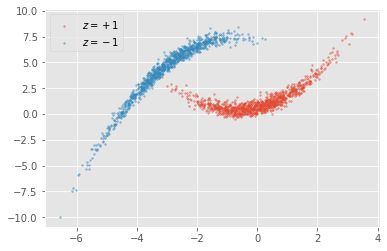

In [ ]:
key = random.PRNGKey(0)

mean = np.array([0,0])
cov = np.array([[1,0.9],[0.9,1]])
alpha = 1.15
beta = 0.5
N = 1000 #number of samples

a1,a2 = jax.random.multivariate_normal(key, mean, cov, (N,)).T
b1,b2 = jax.random.multivariate_normal(key, mean, cov, (N,)).T

x1 = alpha*a1
y1 = a2/alpha + beta*( x1**2 + alpha**2 )

x2 = -alpha*b1 - 3
y2 = b2/alpha - beta*( x2**2 + alpha**2 ) + 10

plt.scatter(x1,y1, s=3, alpha=0.5, label=r'$z=+1$')
plt.scatter(x2,y2, s=3, alpha=0.5,label=r'$z=-1$')
plt.legend()

#### ***(2)*** <br>
Train a Bayesian logistic regression model on the data you have obtained using automatic differentiation variational inference for $5 , 000$ iterations. Plot the decision boundary with 10 representative samples from your model’s predictive posterior distribution. Comment on your results.

##### ***Answer (2)***

In [ ]:
# Permute the data
def shuffle(a, b):
    assert len(a) == len(b)
    p = onp.random.permutation(len(a))
    return a[p], b[p]

epsilon = 1e-5
X1 = np.hstack( (x1.reshape(len(x1),1) , y1.reshape(len(y1),1)) )
X2 = np.hstack( (x2.reshape(len(x2),1) , y2.reshape(len(y2),1)) )
X = np.vstack( (X1,X2) )
y = np.vstack ( (np.zeros((len(X1),1)) , np.ones((len(X2),1))) )
y = y < 1 # Creating boolean labels
y = y.flatten()

#Normalize the data
std = X.std(axis=0)
mean = X.mean(axis=0)
X = (X - mean)/std


#X, y = shuffle(X,y)

n = np.size(X,1)
params = np.zeros((n,1))

In [ ]:
class ADVI_LogisticRegression:
    def __init__(self, X, y, num_mc_samples = 50):
        # Normalize inputs
        self.Xmean, self.Xstd = X.mean(0), X.std(0)
        X = (X - self.Xmean)/self.Xstd
        # Store data
        self.X = X
        self.y = y
        # Number of MC for approximating expectations
        self.num_mc_samples = num_mc_samples
        # Initiatlize parameters of the mean-field variational family
        num_params = X.shape[1]
        init_mean = np.zeros(num_params)
        init_logstd  = np.zeros(num_params)
        self.params = (init_mean, init_logstd)
        # Optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(1e-2)
        self.opt_state = self.opt_init(self.params)
        # Logger to monitor the loss function
        self.loss_log = []
        self.itercount = itertools.count()

    # Define a function to calculate the log likelihood
    def per_sample_elbo(self, params, batch, rng_key):
        X, y = batch
        mean, log_std = params
        # Sample model parameters via the re-parametrization trick
        w = mean + np.exp(log_std) * random.normal(rng_key, mean.shape)
        # Compute log_likelihood
        logit_prob = np.matmul(X, w)
        prob_pres = log_sigmoid(logit_prob)
        prob_abs = log_sigmoid(-logit_prob)
        log_likelihood = np.sum(y * prob_pres + (1 - y) * prob_abs)
        # Compute log_prior
        log_prior = np.sum(norm.logpdf(w))
        # Compute entropy of the variational posterior
        entropy = -np.sum(log_std)
        return entropy - (log_likelihood + log_prior)

    def elbo(self, params, batch, rng_key):
        # Average over a batch of random samples.
        rng_keyes = random.split(rng_key, self.num_mc_samples)
        pe_loss = lambda key: self.per_sample_elbo(params, batch, key)
        loss = vmap(pe_loss)(rng_keyes)
        return np.mean(loss)

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch):
        rng_key = random.PRNGKey(i)
        params = self.get_params(opt_state)
        g = grad(self.elbo)(params, batch, rng_key)
        return self.opt_update(i, g, opt_state)

    def data_stream(self, n, num_batches, batch_size):
        rng = npr.RandomState(0)
        while True:
            perm = rng.permutation(n)
            for i in range(num_batches):
                batch_idx = perm[i*batch_size:(i+1)*batch_size]
                yield self.X[batch_idx, :], self.y[batch_idx]

    def train(self, num_epochs = 100, batch_size = 64):
        n = self.X.shape[0]
        num_complete_batches, leftover = divmod(n, batch_size)
        num_batches = num_complete_batches + bool(leftover)
        batches = self.data_stream(n, num_batches, batch_size)
        pbar = trange(num_epochs)
        for epoch in pbar:
            for _ in range(num_batches):
                batch = next(batches)
                self.opt_state = self.step(next(self.itercount), self.opt_state, batch)
            self.params = self.get_params(self.opt_state)
            loss_value = self.elbo(self.params, batch, random.PRNGKey(0))
            self.loss_log.append(loss_value)
            pbar.set_postfix({'Loss': loss_value})

Text(0, 0.5, 'ELBO loss')

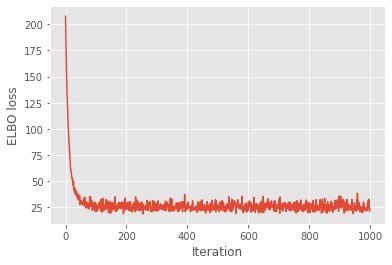

In [ ]:
model = ADVI_LogisticRegression(X, y, num_mc_samples=5)

model.train(num_epochs = 1000, batch_size = 256)

plt.plot(model.loss_log)
plt.xlabel('Iteration')
plt.ylabel('ELBO loss')

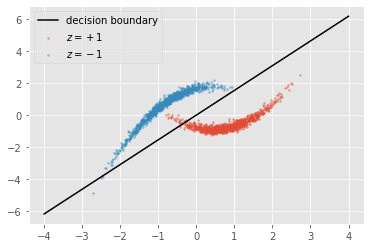

In [ ]:
# Sample variational parameters
num_samples = 100
rng_keyes = random.split(key, num_samples)
opt_params = model.get_params(model.opt_state)
mean, log_std = opt_params
sample_fn = lambda key: mean + np.exp(log_std) * random.normal(key, mean.shape)
samples = vmap(sample_fn)(rng_keyes)
mean_params = np.mean(samples, axis = 0)

#Calculate the decision boundary
x_b = np.linspace(-4,4,100)
w1, w2 = mean_params
y_b = -x_b*(w1/w2)

#Plot the normalized data with the decision boundary
plt.scatter(X[:len(x1),0],X[:len(x1),1], s=3, alpha=0.5, label=r'$z=+1$')
plt.scatter(X[len(x1):,0],X[len(x1):,1], s=3, alpha=0.5, label=r'$z=-1$')
plt.plot(x_b,y_b,label='decision boundary',color='k')
plt.legend()

#### ***(3)***<br>
Replace your logistic regression model with a one hidden-layer neural network and repeat the training and visualization process described in **(2)**. Comment on your results.



##### ***Answer (3)***

In [ ]:
import numpy as np

class FCLayer:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.weights = np.random.randn(input_size, output_size) / np.sqrt(input_size + output_size)
        self.bias = np.random.randn(1, output_size) / np.sqrt(input_size + output_size)

    def forward(self, input):
        self.input = input
        return np.dot(input, self.weights) + self.bias

    def backward(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        # bias_error = output_error

        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error


class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    def forward(self, input):
        self.input = input
        return self.activation(input)

    def backward(self, output_error, learning_rate):
        return output_error * self.activation_prime(self.input)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_prime(x):
    return np.exp(-x) / (1 + np.exp(-x))**2


class FlattenLayer:
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def forward(self, input):
        return np.reshape(input, (1, -1))

    def backward(self, output_error, learning_rate):
        return np.reshape(output_error, self.input_shape)

def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

def mse_prime(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_pred.size


In [ ]:
n = np.size(X,1)
params = np.zeros((n,1))

X = X.reshape(len(X),1,2)
y = y.reshape(len(y),1,1)


network = [
    FCLayer(2, 3),
    ActivationLayer(sigmoid, sigmoid_prime),
    FCLayer(3, 1),
    ActivationLayer(sigmoid, sigmoid_prime)
]

epochs = 700
learning_rate = 0.1

# training

pp = ProgressPlot(plot_names=["Error"],
                  x_lim=[0, epochs],
                  line_names=['Error'])

for epoch in range(epochs):
    error = 0
    for x, y_true in zip(X, y):
        # forward
        output = x
        for layer in network:
            output = layer.forward(output)

        # error (display purpose only)
        error += mse(y_true, output)

        # backward
        output_error = mse_prime(y_true, output)
        for layer in reversed(network):
            output_error = layer.backward(output_error, learning_rate)

    error /= len(X)
    pp.update(error)
    #print('%d/%d, error=%f' % (epoch + 1, epochs, error))

pp.finalize()

In [ ]:
def predict(network, input):
    output = input
    for layer in network:
        output = layer.forward(output)
    return output

#Z = predict(network,X)

xx=np.linspace(-4, 4,100) #bounds of data
yy=np.linspace(-7,7,100)

X11=[]
X22=[]
pred=[]
for point1 in tqdm(xx):
    for point2 in yy:
        X11.append(point1)
        X22.append(point2)
        pred.append(predict(network, np.array([point1,point2]).reshape(1,1,2))) #getting predictions across each point

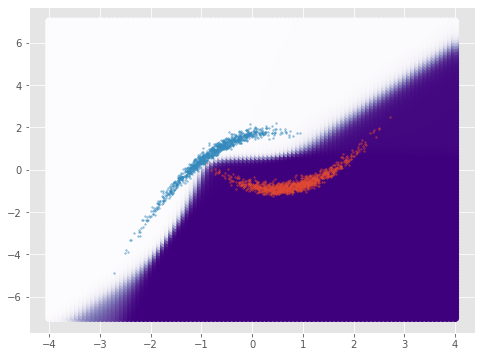

In [ ]:
f, ax1 = plt.subplots(figsize=(8, 6))
#ax.contour(xx, yy, probs, levels=[0.5], cmap="Greys", vmin=0, vmax=.6)
ax1.scatter(X11, X22, c=pred, s=50, linewidth=1, cmap='Purples')
ax1.scatter(X[:len(x1),1,0],X[:len(x1),1,1], s=3, alpha=0.5, label=r'$z=+1$')
ax1.scatter(X[len(x1):,1,0],X[len(x1):,1,1], s=3, alpha=0.5, label=r'$z=+1$')

#f.savefig('NN.png')

It's nice to see how the fairly simple neural network (one hidden layer with three neurons) could handle the nonlinear decision boundary easily - thanks to the nonlinear sigmoid activation function.

## Problem 4

Consider a random variable $X$ distributed as:

$$ X \sim \mathcal{N}(\mu_1 = 30,\sigma_1^2 = 10) + \mathcal{N}(\mu_2 = 80,\sigma_2^2 = 20) $$

Write a code that implements importance sampling and rejection sampling. Use $N = 100 , 000$ samples in order to predict the mean and the variance of the probability density function of $X$ using your rejection sampling and your importance sampling functions. Also, provide histograms of the sampled distributions and compare them with the original one for both cases.

#### ***Answer***

<center><b>Importance Sampling

In [ ]:
import numpy as np

key = random.PRNGKey(0)

sig1, mu1  = np.sqrt(10.0), 30.0
sig2, mu2  = np.sqrt(20.0), 80.0
N = 1000 # samples

x1 = jax.random.normal(key, (N,))
x1 = sig1 * x1 + mu1

x2 = jax.random.normal(key, (N,))
x2 = sig2 * x2 + mu2

x = x1 + x2

mu_p = mu1 + mu2
sig_p = np.sqrt(sig1**2 + sig2**2)

p_x = stats.norm(mu_p , sig_p ) #Generating p(x)
g_x = stats.uniform(90,40) #Generating Unifrom distribution for q(x)

# Calculating the real expected value and variance of p(x)

sum = 0
sum_s = 0
N = 10000

for i in tqdm(range(N)):
    # draw a sample
    x_i = np.random.normal(mu_p, sig_p)
    sum += x_i
    sum_s += x_i**2

E_p = sum/N
V_p = sum_s/N - (sum/N)**2
print("mean of p(x) = ", E_p)
print("variance of p(x) = ", V_p)


mean of p(x) =  109.97928378118779
variance of p(x) =  29.90473284564905


In [ ]:
# Using importance sampling to approximate the expected value & varaince above

N = 10000 #Number of samples

value1_list = []
value2_list = []
samples_list =[]

for i in tqdm(range(N)):
    key = random.PRNGKey(i)
    x_i = random.uniform(key, minval=90.0,maxval=130.0)
    value1 = x_i*(p_x.pdf(x_i) / g_x.pdf(x_i))
    value1_list.append(value1)
    samples_list.append(x_i)

E_app = np.mean(value1_list) #Calculating mean

for i in tqdm(range(N)):
  key = random.PRNGKey(i)
  x_i = random.uniform(key, minval=90.0,maxval=130.0)
  value2 = ((x_i - E_app)**2)*(p_x.pdf(x_i) / g_x.pdf(x_i))
  value2_list.append(value2)


V_app = np.mean(value2_list) #Calculating variance

print("Approximated mean = {:0.2f}, Accuracy = {:0.2f}%".format(E_app, 100 - (abs(E_app - E_p)/E_p)*100 ) )
print("Approximated variance = {:0.2f}, Accuracy = {:0.2f}%".format(V_app, 100 - (abs(V_app - V_p)/V_p)*100 ) )


Approximated mean = 107.75, Accuracy = 97.98%
Approximated variance = 35.01, Accuracy = 82.94%


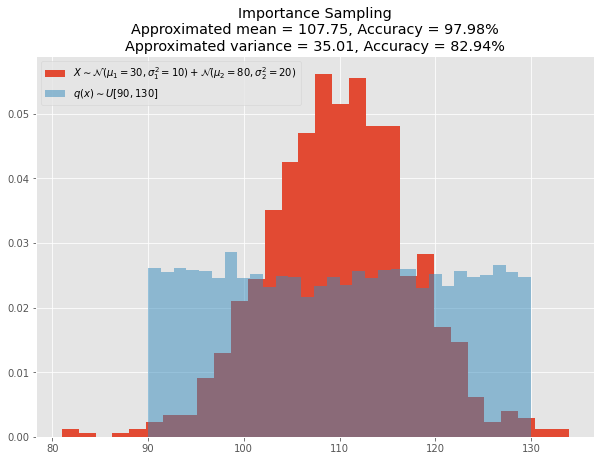

In [ ]:
# Plotting the target samples and the proposed one
plt.figure(figsize=[10, 7])
plt.hist(x, bins=30, density=True, label=r'$X \sim \mathcal{N}(\mu_1 = 30,\sigma_1^2 = 10) + \mathcal{N}(\mu_2 = 80,\sigma_2^2 = 20)$')
plt.hist(samples_list, bins=30, density=True, label=r'$q(x) \sim U[90,130]$', alpha=0.5)
plt.title('Importance Sampling' + '\n' +
          "Approximated mean = {:0.2f}, Accuracy = {:0.2f}%".format(E_app, 100 - (abs(E_app - E_p)/E_p)*100 ) + '\n' +
          "Approximated variance = {:0.2f}, Accuracy = {:0.2f}%".format(V_app, 100 - (abs(V_app - V_p)/V_p)*100 ))
plt.legend()

<center><b>Rejection Sampling

In [ ]:
xx = np.linspace(91,129,1000)
#The factor that would multiply the pdf to create the envelope:
k = max( p_x.pdf(xx) / g_x.pdf(xx) )

N = 10000

samp_rej = []

for i in tqdm(range(N)):
  key = random.PRNGKey(i)
  x_i = np.random.uniform(91,129)
  u = random.uniform( key, minval= 0,maxval= k*g_x.pdf(x_i) )

  if u <= p_x.pdf(x_i):
    samp_rej.append(x_i)

E_rej = np.mean(samp_rej)
V_rej = np.var(samp_rej)

print("Approximated mean = {:0.2f}, Accuracy = {:0.2f}%".format(E_rej, 100 - (abs(E_rej - E_p)/E_p)*100 ) )
print("Approximated variance = {:0.2f}, Accuracy = {:0.2f}%".format(V_rej, 100 - (abs(V_rej - V_p)/V_p)*100 ) )


Approximated mean = 109.88, Accuracy = 99.91%
Approximated variance = 30.08, Accuracy = 99.41%


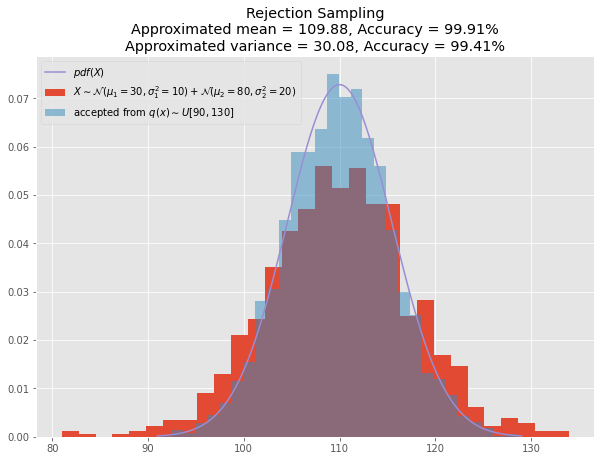

In [ ]:
# Plotting the target samples and the proposed one
plt.figure(figsize=[10, 7])
plt.hist(x, bins=30, density=True, label=r'$X \sim \mathcal{N}(\mu_1 = 30,\sigma_1^2 = 10) + \mathcal{N}(\mu_2 = 80,\sigma_2^2 = 20)$')
plt.hist(samp_rej, bins=30, density=True, label=r'accepted from $q(x) \sim U[90,130]$', alpha=0.5)
plt.plot(xx,p_x.pdf(xx), label=r'$pdf(X)$')
plt.title('Rejection Sampling' + '\n' +
          "Approximated mean = {:0.2f}, Accuracy = {:0.2f}%".format(E_rej, 100 - (abs(E_rej - E_p)/E_p)*100 ) + '\n' +
          "Approximated variance = {:0.2f}, Accuracy = {:0.2f}%".format(V_rej, 100 - (abs(V_rej - V_p)/V_p)*100 ))
plt.legend()

## Problem 5

Recall HW2 Question 3, where you derived the conditional distribution of a Bayesian regression model with a likelihood $p ( y | x , α , β , γ )$ corresponding to a linear observation model is $y = α x + β + ϵ$ . Noting that $γ$ represents the noise level in the observed data, i.e. it corresponds to the precision of the data likelihood. In this case, the likelihood can be further expressed as:

$$ p(y\lvert x, \alpha, \beta, \gamma) = (\sqrt{\frac{\gamma}{2\pi}})^n\exp(-\frac{\gamma(\sum_{i=1}^n\|y_i - x_i\alpha - \beta\|^2_2)}{2}) $$
<br>

while the conditional posteriors are:<br>
$p(\alpha\lvert x, y, \beta, \gamma) = \mathcal{N}(\mu_1,\frac{1}{\lambda_1})$, where $\mu_1 = \frac{\gamma \sum_{i=1}^{n}x_i(y_i-\beta)}{1+\gamma \sum_{i=1}^{n}x_i^2}$ and $\lambda_1 = 1+\gamma \sum_{i=1}^{n}x_i^2$ <br><br>

$p(\beta\lvert x, y, \alpha, \gamma) = \mathcal{N}(\mu_2,\frac{1}{\lambda_2})$, where $\mu_2 = \frac{\gamma \sum_{i=1}^{n}(y_i-x_i\alpha)}{n\gamma+1}$ and $\lambda_2 = n\gamma+1$ <br><br>

$p(\gamma\lvert x, y, \alpha, \beta) =  \text{Gam}(a,b)$, where $a=\frac{n}{2}+2$ and $b = \frac{1}{2}[2+\sum_{i=1}^{n}(y_i-x_i\alpha-\beta)^2]$ <br><br>

*(1)* <br>
Implement the Gibbs sampling algorithms using the above conditional posteriors to generate $5 , 000$ samples from the target posterior distribution $p ( α , β , γ | x , y )$ . Discard the first $2,000$ as a burn-in phase and plot a histogram generated from your samples. Also, please draw some samples of linear lines using $50$ samples you got.

#### ***Answer (1)***

Text(0, 0.5, 'y')

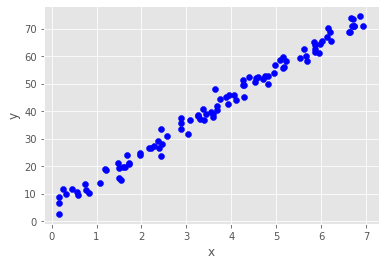

In [ ]:
import numpy as np

key = random.PRNGKey(0)
key2 = random.PRNGKey(1)

alpha_t = 10.0
beta_t = 5.0
gamma_t = 0.2
sig = 1/np.sqrt(gamma_t)
n = 100

x = random.uniform(key, shape=(n,), minval=0.0, maxval=7.0)
y = beta_t + alpha_t*x + sig*random.normal(key2, shape=(n,))

plt.scatter(x,y,color='b')
plt.xlabel("x")
plt.ylabel("y")

In [ ]:
def sample_beta(y, x, alpha, gamma):
    N = len(y)
    assert len(x) == N
    precision = N*gamma + 1
    mean =  gamma * np.sum(y - alpha * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))

def sample_alpha(y, x, beta, gamma):
    N = len(y)
    assert len(x) == N
    precision = 1 + gamma * np.sum(x * x)
    mean =  gamma * np.sum( (y - beta) * x)
    mean /= precision
    return np.random.normal(mean, 1 / np.sqrt(precision))


def sample_gamma(y, x, beta, alpha):
    N = len(y)
    alpha_new = (N / 2) + 2
    resid = y - beta - alpha * x
    beta_new = (2 + np.sum(resid * resid)) / 2
    return np.random.gamma(alpha_new, 1 / beta_new)


def Gibbs(y, x, iters):
    assert len(y) == len(x)
    beta = 0.0
    alpha = 0.0
    gamma = 0.0

    trace = np.zeros((iters, 3)) ## trace to store values of parameters

    pp = ProgressPlot(plot_names=["sampled parameters"],
                  line_names=[r'α', r'β', r'γ'],
                  x_lim=[0, iters])

    for i in range(iters):
        beta = sample_beta(y, x, alpha, gamma)
        alpha = sample_alpha(y, x, beta, gamma)
        gamma = sample_gamma(y, x, beta, alpha)
        trace[i,:] = np.array((beta, alpha, gamma))

        pp.update([[alpha, beta, gamma]])

    trace = pd.DataFrame(trace)
    trace.columns = [r'$\beta$', r'$\alpha$', r'$\gamma$']

    pp.finalize()

    return trace

In [ ]:
iters = 2000
trace = Gibbs(y, x, iters)

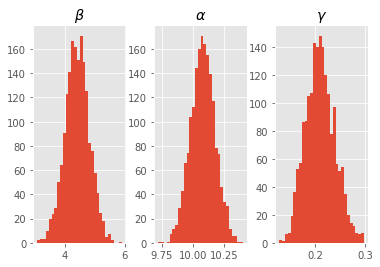

In [ ]:
trace_burnt = trace[200:]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,3))

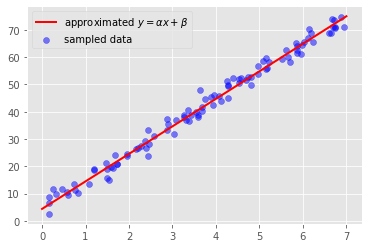

In [ ]:
Beta, Alpha, Gamma = trace_burnt.median()
X = np.linspace(0,7,200)
Y = Beta + Alpha*X

plt.scatter(x,y, alpha=0.5, label ='sampled data', color='b')
plt.plot(X,Y, linewidth=2.0, color='r', label=r'approximated $y = \alpha x + \beta$')
plt.legend()

#### ***(2)*** <br>
Gibbs sampling depends on deriving an analytical expression of the corresponding conditional posterior distributions. However, this cannot be done in many applications. Assume that you only have access to the unnormalized posterior, i.e.

$$ p(y\lvert x, \alpha, \beta, \gamma) = (\frac{\gamma}{\sqrt{2\pi}})^n\exp(-\frac{\gamma(\sum_{i=1}^n\|y_i - x_i\alpha - \beta\|^2_2)}{2}) $$ <br>

where the prior distributions are the same as before. Implement the Metropolis algorithm to sample 5 , 000 samples from the target posterior distribution $p ( α , β , γ | x , y )$ . Discard the first $2,000$ as a burn-in phase and plot a histogram generated from your samples. Please compare these histograms with the plots from Gibbs sampling. Also, please draw some samples of linear lines using $50$ samples you got.

In [ ]:
def log_like(x, y, alpha, beta, gamma):
  n = len(y)
  a = n * np.log( np.sqrt( (gamma/(2*np.pi)) ) )
  b = - (gamma/2) * np.sum( (y - x*alpha - beta)**2 )
  return a + b

def log_gamma(x):
  return np.log(0.5) + np.log(x) - x

def log_alpha_beta(x):
  return np.log( 1/np.sqrt(2*np.pi) ) - 0.5*x**2



N = 10000 #iternations

acc_alpha = []
acc_beta = []
acc_gamma = []

#Initial guess
beta = 3.5 # true 5
alpha = 9.0 # true 10
gamma = 1.5 # true 0.2

#hyper parameters
a = 1.0
b = 1.0
c = 1.0


pp = ProgressPlot(plot_names=["sampled parameters"],
                  line_names=[r'α', r'β', r'γ'],
                  x_lim=[0, N])

for i in range(N):

  #Proposed parameters
  #gam_N = np.random.normal(0, c) + gamma
  #alp_N = np.random.normal(0, a) + alpha
  #bet_N = np.random.normal(0, b) + beta

  gam_N = np.random.uniform(gamma - 0.07 , gamma + 0.07)
  alp_N = np.random.uniform(alpha - 0.07 , alpha + 0.07)
  bet_N = np.random.uniform(beta - 0.07 , beta + 0.07)

  log1 = (log_like(x,y,alpha,beta,gamma) +
         log_alpha_beta(alpha) + log_alpha_beta(beta) +
         log_gamma(gamma))

  log11 = (log_like(x,y,alp_N,bet_N,gam_N) +
          log_alpha_beta(alp_N) + log_alpha_beta(bet_N) +
          log_gamma(gam_N))

  accept = log11 - log1
  accept = min([0, accept])
  accept = np.exp(accept)

  pp.update([[alpha, beta, gamma]])

  if np.random.uniform(0,1)<accept:
    gamma=gam_N
    beta=bet_N
    alpha=alp_N

  else:
      gamma=gamma
      beta=beta
      alpha=alpha

  acc_alpha.append(alp_N)
  acc_beta.append(bet_N)
  acc_gamma.append(gam_N)


pp.finalize()

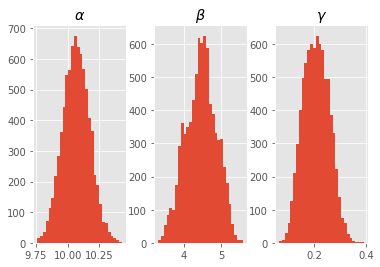

In [ ]:
 Metropolis = pd.DataFrame(
    {'alpha': acc_alpha,
     'beta': acc_beta,
     'gamma': acc_gamma
    })
Metropolis.columns = [r'$\alpha$', r'$\beta$', r'$\gamma$']

trace_burnt = Metropolis[2000:]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,3))

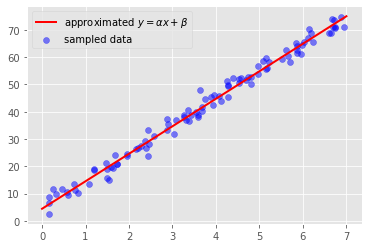

In [ ]:
Alpha, Beta, Gamma = trace_burnt.mean()
X = np.linspace(0,7,200)
Y = Beta + Alpha*X

plt.scatter(x,y, alpha=0.5, label ='sampled data', color='b')
plt.plot(X,Y, linewidth=2.0, color='r', label=r'approximated $y = \alpha x + \beta$')
plt.legend()